In [91]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV

sns.set_style('whitegrid')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [92]:
TRAIN_DATA_PATH = './train.csv'
TEST_DATA_PATH = './test.csv'

origin_train = pd.read_csv(TRAIN_DATA_PATH)
origin_test = pd.read_csv(TEST_DATA_PATH)

In [93]:
features = origin_train.columns[2:]
target = pd.DataFrame(origin_train, columns=['target'])
df_train = pd.DataFrame(origin_train, columns=features)
df_test = pd.DataFrame(origin_test, columns=features)

In [94]:
"""
trainとtestの新しい特徴量を作る関数
feature_num = var_{feature_num}の特徴量を作る
"""

feature_num = 5

def new_feature(df_train, df_test, feature_num):   
    new_train = pd.DataFrame([])
    new_test = pd.DataFrame([])
    for i in range(0, 200):
        new_train[f'var_{feature_num}_{i}'] = df_train[f'var_{feature_num}'] + df_train[f'var_{i}']
        new_test[f'var_{feature_num}_{i}'] = df_test[f'var_{feature_num}'] + df_test[f'var_{i}']
    return new_train, new_test

In [95]:
"""
ストレージに余裕があればfeature_numをfor文で回して特徴量ごとのcsvファイル作ってあとでまとめて学習も有り
そのまま学習したければ下記の関数はコメントアウトして大丈夫
"""


def new_feature_csv():
    train_id = pd.DataFrame(origin_train['ID_code'])
    test_id= pd.DataFrame(origin_test['ID_code'])
    new_train, new_test = new_feature(df_train, df_test, feature_num)
    new_train_df = pd.concat([train_id, target, new_train], axis=1)
    new_test_df = pd.concat([test_id, new_test], axis=1)
    new_train_df.to_csv(f'train_new_var_{feature_num}.csv', index=False)
    new_test_df.to_csv(f'test_new_var_{feature_num}.csv', index=False)

'\nストレージに余裕があればfeature_numをfor文で回して特徴量ごとのcsvファイル作ってあとでまとめて学習も有り\nそのまま学習したければ下記の関数はコメントアウトして大丈夫\n'

In [102]:
"""
元のデータとスタックして学習させたいときはこの関数使う
スタックしないで学習するときはnew_featureの戻り値をtrain, testで受け取って学習させる
"""

def stack_data():
    new_train, new_test = new_feature(df_train, df_test, feature_num)
    train = pd.concat([df_train, new_train], axis=1)
    test = pd.concat([df_test, new_train], axis=1)
    return train, test, new_train

train, test, new_train = stack_data()
features = new_train.columns

In [104]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [105]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 100000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = features
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.847401	valid_1's auc: 0.81403
[2000]	training's auc: 0.869752	valid_1's auc: 0.830231
[3000]	training's auc: 0.882351	valid_1's auc: 0.837653
[4000]	training's auc: 0.892006	valid_1's auc: 0.842826
[5000]	training's auc: 0.899885	valid_1's auc: 0.846762
[6000]	training's auc: 0.906451	valid_1's auc: 0.849285
[7000]	training's auc: 0.912541	valid_1's auc: 0.850926
[8000]	training's auc: 0.918048	valid_1's auc: 0.852658
[9000]	training's auc: 0.922998	valid_1's auc: 0.853837
[10000]	training's auc: 0.927509	valid_1's auc: 0.854699
[11000]	training's auc: 0.93187	valid_1's auc: 0.855434
[12000]	training's auc: 0.935815	valid_1's auc: 0.85594
[13000]	training's auc: 0.939588	valid_1's auc: 0.856377
[14000]	training's auc: 0.943223	valid_1's auc: 0.857194
[15000]	training's auc: 0.946628	valid_1's auc: 0.857644
[16000]	training's auc: 0.949824	valid_1's auc: 0.85819
[17000]	training's auc: 0.9528

[10000]	training's auc: 0.927159	valid_1's auc: 0.856295
[11000]	training's auc: 0.931403	valid_1's auc: 0.857298
[12000]	training's auc: 0.93535	valid_1's auc: 0.858452
[13000]	training's auc: 0.939154	valid_1's auc: 0.85923
[14000]	training's auc: 0.942618	valid_1's auc: 0.859996
[15000]	training's auc: 0.946047	valid_1's auc: 0.860642
[16000]	training's auc: 0.949357	valid_1's auc: 0.861225
[17000]	training's auc: 0.952421	valid_1's auc: 0.861703
[18000]	training's auc: 0.955358	valid_1's auc: 0.862127
[19000]	training's auc: 0.958156	valid_1's auc: 0.862425
[20000]	training's auc: 0.960761	valid_1's auc: 0.862811
[21000]	training's auc: 0.963284	valid_1's auc: 0.862869
[22000]	training's auc: 0.96564	valid_1's auc: 0.863213
[23000]	training's auc: 0.967873	valid_1's auc: 0.863162
[24000]	training's auc: 0.969999	valid_1's auc: 0.863386
[25000]	training's auc: 0.972052	valid_1's auc: 0.863462
[26000]	training's auc: 0.973929	valid_1's auc: 0.863444
[27000]	training's auc: 0.97572	va

[23000]	training's auc: 0.967931	valid_1's auc: 0.867311
[24000]	training's auc: 0.969969	valid_1's auc: 0.867525
[25000]	training's auc: 0.972001	valid_1's auc: 0.867593
[26000]	training's auc: 0.973919	valid_1's auc: 0.867753
[27000]	training's auc: 0.975655	valid_1's auc: 0.867739
[28000]	training's auc: 0.977366	valid_1's auc: 0.867705
[29000]	training's auc: 0.978969	valid_1's auc: 0.867781
[30000]	training's auc: 0.980453	valid_1's auc: 0.867783
[31000]	training's auc: 0.981859	valid_1's auc: 0.867775
Early stopping, best iteration is:
[28527]	training's auc: 0.978245	valid_1's auc: 0.867911
Fold 9
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.845875	valid_1's auc: 0.806017
[2000]	training's auc: 0.869618	valid_1's auc: 0.825421
[3000]	training's auc: 0.882477	valid_1's auc: 0.835265
[4000]	training's auc: 0.891804	valid_1's auc: 0.841033
[5000]	training's auc: 0.89955	valid_1's auc: 0.84526
[6000]	training's auc: 0.906163	valid_1's auc:

In [128]:
# feature_importance.sort_values('importance', ascending=False)
feature_importance

,Feature,importance,fold
0,var_5_0,2121,1
1,var_5_1,2000,1
2,var_5_2,2338,1
3,var_5_3,1173,1
4,var_5_4,1202,1
5,var_5_5,758,1
6,var_5_6,2397,1
7,var_5_7,1279,1
8,var_5_8,1400,1
9,var_5_9,1870,1


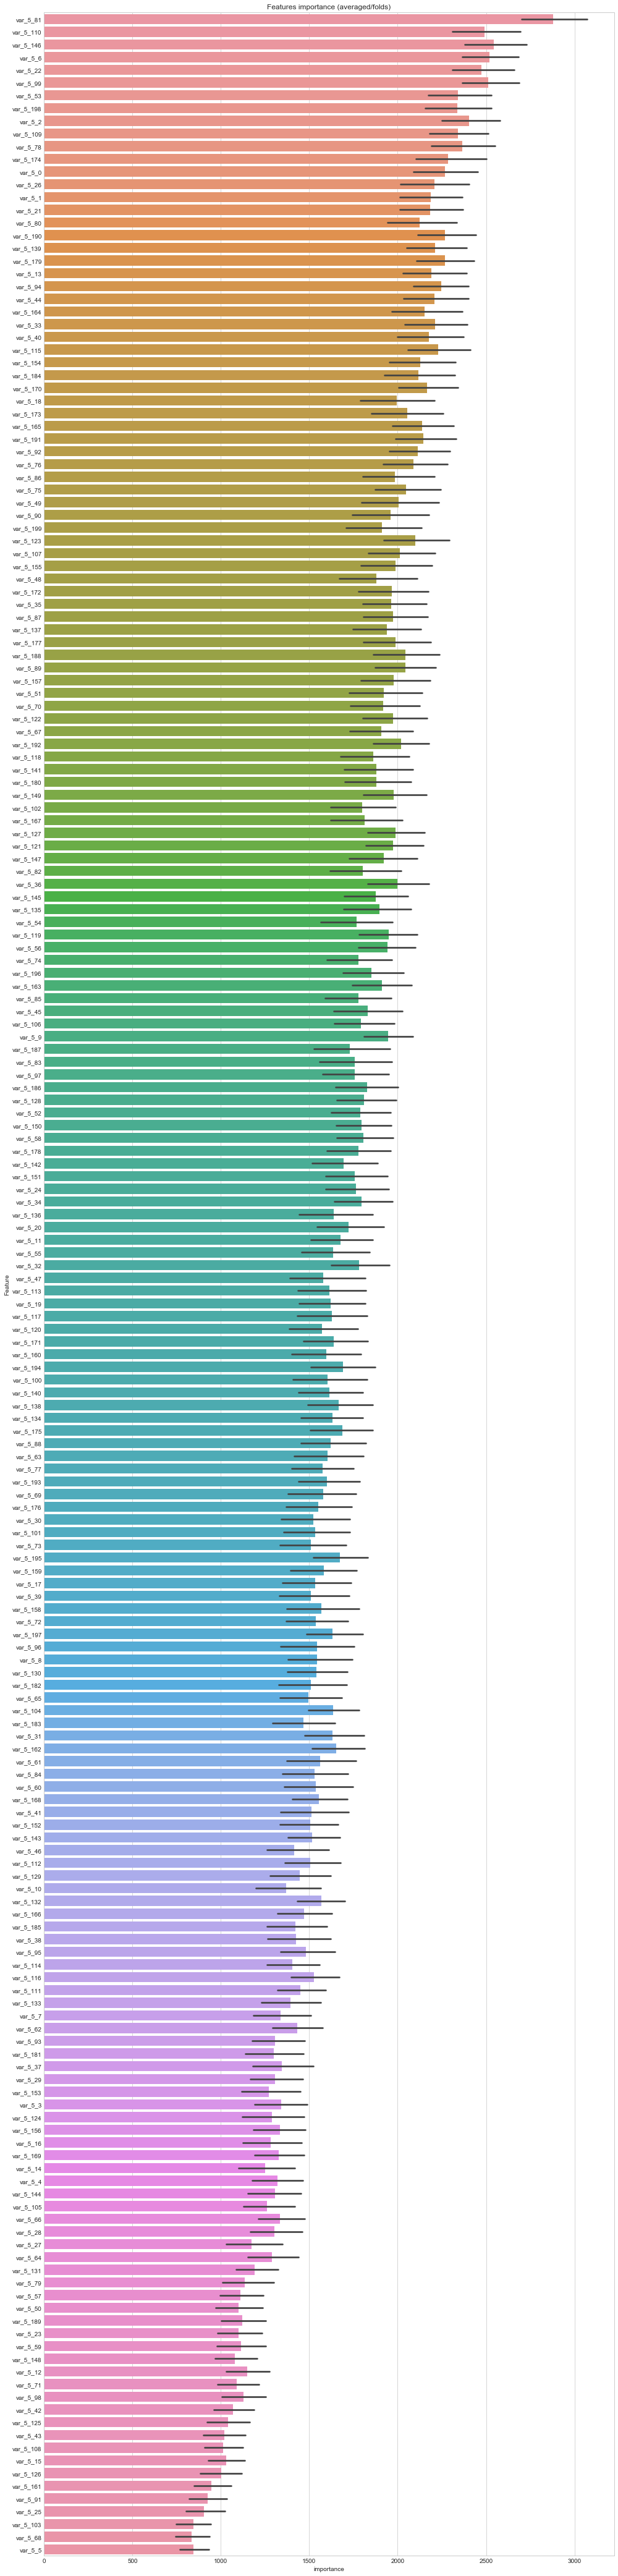

In [106]:
cols = (feature_importance[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:6000].index)
best_features = feature_importance.loc[feature_importance.Feature.isin(cols)]

plt.figure(figsize=(14,30))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

In [74]:
importance = pd.concat([origin_test['ID_code'], feature_importance], axis=1)

ValueError: Shape of passed values is (4, 203582), indices imply (4, 200000)

In [73]:
score = round(roc_auc_score(target, oof), 4)
sub = pd.DataFrame({"ID_code": origin_test.ID_code.values})
sub["target"]=predictions
sub.to_csv(f"submission_new_var{feature_num}_{score}.csv", index=False)